In [4]:
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.patches 
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
import sys
import os
import os.path

In [5]:
f = h5py.File("../CXI/cxi25410/res/iceFinderCampaign/output_r0144/type1/LCLS_2011_Feb28_r0144_163006_2feb_cspad.h5", 'r')
d = f['data/data'][:]
wavelength = f['LCLS/photon_wavelength_A'][0]/1e10
detector_distance = f['LCLS/detectorPosition'][0]/1000
pixel_size = 109.92*1e-6

In [6]:
# calculate qx, qy
image = d
center = None
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (image.shape[1]-1)/2
    yy = yy.astype(np.float64) - (image.shape[0]-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

In [7]:
threshold = 2*(np.mean(image)+np.std(image))

In [8]:
# method 2 thresholding the whole image and set everything below threshold equal to zero
## find peak regions based on the value of the threshold
image_thresholded = np.copy(image)
image_thresholded[image<threshold] = 0
#find the peak regions and label all the pixels
labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded)
peak_regions = scipy.ndimage.find_objects(labeled_image)

In [9]:
peak_list = []
centroid_list = []
for peak_region_i in peak_regions:
    if d[peak_region_i].shape[0]>15 and d[peak_region_i].shape[1]>15:
        cx = np.sum(d[peak_region_i]*qx[peak_region_i])/np.sum(d[peak_region_i])
        cy = np.sum(d[peak_region_i]*qy[peak_region_i])/np.sum(d[peak_region_i])
        peak_list.append(d[peak_region_i])
        centroid_list.append((cx,cy))

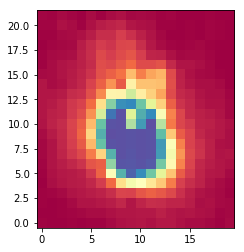

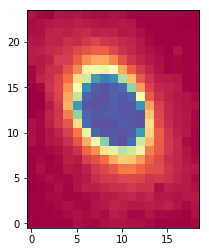

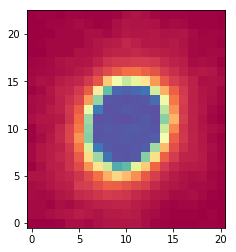

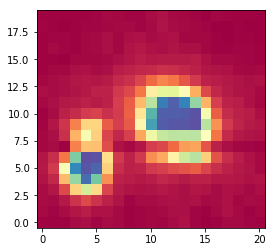

In [10]:
for i in range(len(peak_list)):
    plt.figure()
    plt.imshow(peak_list[i], interpolation='nearest', origin='lower', cmap=plt.get_cmap('Spectral'))